## **1. Defining multiple tools**

Now that we know how to integrate external tools with chatbots, let's learn how to build a multiple-tool chatbot that can automate selecting a tool per query.

### **Enhancing an education chatbot**

Let's imagine our school wants to enhance their chatbot further.:
- For _history_ lessons, they'd like to incorporate a tool that looks up _historical events_. 
- or _English_ lessons, they'd like to feature a _palindrome_ tool that checks whether a specific string is the same when reversed, for example the word "level", or the phrase "top spot".

We can use a different approach for each tool:
- For historical events, we'll create a tool that directly _invokes the LLM_ to look up natural language dates, such as "5th of November".
- To build a palindrome checker, we'll use standard Python to compare a reversed string to its original <br>
  eg. `string == string[::-1]`

Let's code the historical events tool first.

### **Historical events tool**

We'll label our tool with the LangChain $\textcolor{green}{\text{@tool}}$ decorator, helping the LLM to identify custom tools.

Next, we'll call this tool `“date_checker”`, setting it to expect dates as _strings_. <br>
We'll then write a docstring that provides the LLM with a general instruction to return important historical events by date. 

Next, we'll set up a _try-except_ block for different outputs. Within the try-except block, we'll use the `.invoke()` method to invoke the LLM with the given `date`, passing another instruction that events must relate to the provided date. After saving the response in a variable called `"answer"`, we'll return its content. 

If the LLM fails to respond, we'll define an `exception` that returns an error message.

In [1]:
# Import the necessary libraries
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
import os

# Set up the API key
api_key = os.environ["OPENAI_API_KEY"]

# Define the llm
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

######## ######## ########

# Use a decaorator to label the tool and set the input format to string
@tool
def date_checker(date:str) -> str:
    """Provide a list of important historical events for a given date in any format."""
    try:
        # Invoke the LLM to interpret the date and generate historical events
        answer = llm.invoke(f"List important historical events that occured on {date}")

        # Return the response
        return answer.content

    # Set an exception block for errors in retrieval
    except Exception as e:
        return f"Error retrieving events: {str(e)}"

### **Palindrome tool**

Next, we'll create our palindrome tool. Starting with a $\textcolor{green}{\text{@tool}}$ decorator, we'll name the tool "`check_palindrome`", then set the expected input to _string_. <br>
Then we'll create a docstring with an instruction to check for a palindrome. 

We'll clean our text using `.isalnum()` to remove any _non-alphanumeric_ characters and use `.lower()` to turn the remaining characters into _lowercase_, saving the result as a variable called "`cleaned`". 

Next, we set up an _if-else_ statement that checks if the reversed version of "`cleaned`" is identical to the original, returning the appropriate response.

In [2]:
@tool
# Set input format to string
def check_palindrome(text: str):
    """Check if a word or phrase is palindrome."""

    # Remove non-alphanumeric characters and convert to lowercase
    cleaned = ''.join(char.lower() for char in text if char.isalnum())

    # Check if the reversed text is the same as original text
    if cleaned==cleaned[::-1]:
        return f"The phrase or word '{text}' is a palindrome."
    else:
        return f"The phrase or word '{text}' is not a palindrome."

### **Binding multiple tools**

Now we'll add these tools to a new chatbot. 

We'll import the `ToolNode` sub-module from `langgraph.prebuilt`, defining our tools list with the original `wikipedia_tool`, `date_checker`, and `check_palindrome` tools. This list could feature any tools you'd like your chatbot to have. 

We'll then create a `tool_node`, passing `"tools"` to the `ToolNode()` class. 

Finally, we'll bind the tools to our `llm`, creating `"model_with_tools"` using the `.bind_tools()` method.

Note: Since `wikipedia_tool` is defined in the previous chapter, we'll define it again here first.

In [3]:
# Import modules required for defining tool nodes
from langgraph.prebuilt import ToolNode

# Import Wikipedia tool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# initialize Wikipedia API wrapper to fetch top 1 result
api_wrapper = WikipediaAPIWrapper(top_k_results=1)

# Create a Wikipedia query tool using the API wrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [4]:
# List of tools
tools = [wikipedia_tool, date_checker, check_palindrome]

# Pass the tools to the ToolNode()
tool_node = ToolNode(tools)

# Bind tools to the LLM
model_with_tools = llm.bind_tools(tools)

## **2. Defining nodes and edges for flexible function calling**

Now that our palindrome, historical events, and Wikipedia tools are ready to go, let's incorporate them into a new chatbot workflow.

### **Define workflow functions**

Let's start building the first of two workflow functions, which is a __stopping function__ that 
- check for tools calls, or
- end the conversation if there is no tool call in the last message.

The next function is a __dynamic tool caller__ that
- returns a tool response if tool call present, or
- invokes the LLm with chatbot node if there are no tool calls.

Once these functions are set u, we'll define the full graph.

### **Create a stop condition function**

To build the workflow, we'll import the `MessagesState`, `START`, and `END` modules from `langgraph.graph`. 

Then, we'll define the stop condition function called "`should_continue`" that accepts `MessagesState` to define the graph state. We'll then extract the last message from "`messages`" in "`state`" and save it as `last_message`. 

Then we'll check if this message has tool calls, such as "`wikipedia`", returning "`tools`" if the condition is true. If not, the conversation is ended using "`END`".

In [5]:
from langgraph.graph import MessagesState, START, END

# Use MessagesState to define the state of the stopping function
def should_continue(state: MessagesState):

    # Get the last message from the state
    last_message = state["messages"][-1]

    # Check if the last message includes tool callls
    if last_message.tool_calls:
        return "tools"
    
    # End the conversation if no tool calls are present
    return END

### **Create a dynamic tool caller**

Next, we'll create our dynamic tool caller named "`call_model`", which also accepts `MessagesState` as the graph state, saving the last message as a variable called `last_message`. 

Then we'll use `isinstance()` to check if this message is an `AIMessage` from the chatbot and whether it features `tool_calls`. <br>
If so, we'll return the "`response`" from "`tool_calls`", passed to the content field of the `AIMessage`. <br>
If there are no `tool_calls`, we'll invoke the model using all of the "`messages`" in the state, passed as an argument to the `.invoke()` method before it's applied to `model_with_tools`.

In [6]:
# Need to import the AIMessage class
from langchain_core.messages import AIMessage

# Extract the last message from the history
def call_model(state: MessagesState):
    last_message = state["messages"][-1]

    # If the last message has tool calls, return the tool's response
    if isinstance(last_message, AIMessage) and last_message.tool_calls:

        # Return the messages from the tool call
        return {"messages": [AIMessage(content=last_message.tool_calls[0]["response"])]}
    
    # Otherwise, proceed with a regular LLM response
    return {"messages": [model_with_tools.invoke(state["messages"])]}

### **Create the graph**

Sinve we've now got our functions, let's create the full graph!

Our graph state called "`workflow`" will be created for us using the `MessagesState` passed to `StateGraph()`.

Then we'll add our nodes to the workflow, mapping the "`chatbot`" to the "`call_model`" function, and "`tools`" to our `tool_node`.

We'll then add a `START` node that initializes the "`chatbot`" node, before adding conditional edges from the "`chatbot`" to the `END` or "`tools`" nodes using our "`should_continue`" function.

Next, we'll add another edge from the "`tool`" node back to the "`chatbot`", completing the conversation loop.

In [7]:
# Import required classes
from langgraph.graph import StateGraph

workflow = StateGraph(MessagesState)

# Add nodes for chatbot and tools
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node)

# Connect the START node to the chatbot
workflow.add_edge(START, "chatbot")

# Define conditions, then loop back to chatbot
workflow.add_conditional_edges("chatbot", should_continue, ["tools", END])
workflow.add_edge("tools", "chatbot")

### **Adding memory**

We'll then create a `MemorySaver()` object called `"memory"`, which we'll use to enhance our chatbot with memory. 

Next, we'll apply the `.compile()` method to our workflow, passing in the memory to the "`checkpointer`" to create the chatbot application, before displaying the LangGraph diagram. Later on, we'll test this workflow with different queries.

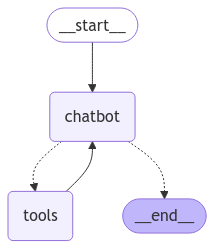

In [8]:
# Import the necessary classes
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# Set up memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

## **3. Organize chatbot outputs with memory**

### **Streaming multiple tool outputs**

Now that our workflow is ready, we can test it! We'll first see whether the chatbot can answer a query by picking the correct tool. Then, we'll determine if the chatbot can interleave the user's queries with answers to follow-up questions.

<div style="display: flex;">
    <!-- Left Column -->
    <div style="width: 25%; padding: 10px;">
    Now that our workflow is ready, we can test it! We'll first see whether the chatbot can answer a query by picking the correct tool. Then, we'll determine if the chatbot can interleave the user's queries with answers to follow-up questions.
    </div>
    <!-- Right Column -->
    <div style="width: 48%; padding: 10px;">
        <li><b>print outputs with multiple tools</b></li> <br>
        <img src='./images/outputs.png' width=45%> <br><br>
        <li><b>print outputs with multiple tools</b></li> <br>
        <img src='./images/memory.png' width=45%>
    </div>
</div>


To get started, we'll import the `AIMessage` and `HumanMessage` modules from the `langchain_core.messages` module, with a config variable set to one session. 

We'll create a function called `multi_tool_output` to handle queries for different tools. 

First, we'll define an "`inputs`" dictionary including the user's query as a `HumanMessage`, passed within the "`content`" field. 

Next, we'll stream messages and metadata using `app.stream()`, which accepts the "`inputs`" and "`config`", with "`stream_mode`" set to "`messages`" to enable real-time output. <br>
For each message, if msg.`content` is not a `HumanMessage`, we'll print its contents to access just the chatbot responses. <br>
We'll set the "`end`" parameter to an empty string to avoid excess line breaks, with "`flush`" set to "`True`" to ensure live outputs. <br>
A line-space will separate the answers for different queries.

In [9]:
from langchain_core.messages import AIMessage, HumanMessage

config = {"configurable": {"thread_id": "1"}}

# Create inout message with the user's query
def multi_tool_output(query):
    inputs = {"messages": [HumanMessage(content=query)]}

    # Stream messages and metadata from the chatbot application
    for msg, metadata in app.stream(inputs, config, stream_mode="messages"):

        # Check if the message has content and is not from a human
        if msg.content and not isinstance(msg, HumanMessage):
            print(msg.content, end="", flush=True)
    
    print("\n")

### **Test with multiple tools**

Let's test this function with two queries using different tools. The first query should trigger the palindrome tool, since the question asks `"Is 'Stella won no wallets' a palindrome?"`. 

The second query should trigger the historical events tool, asking `"What happened on April 12th, 1955?"`.

For each query, the chatbot will return a direct tool response before the LLM refines the output. 

In [10]:
multi_tool_output("Is `Stella won no wallets` a palindrome?")
multi_tool_output("What happened on April 12th, 1955?")

The phrase or word 'Stella won no wallets' is a palindrome.Yes, the phrase "Stella won no wallets" is a palindrome.

On April 12, 1955, one notable historical event occurred: **The first successful polio vaccine was announced by Dr. Jonas Salk**. On this day, Salk's vaccine was deemed effective in preventing poliomyelitis, a viral disease that had caused widespread fear and paralysis, particularly among children. This announcement marked a significant milestone in medical history and public health, leading to widespread vaccination campaigns and a dramatic decrease in polio cases in the following decades. 

If you're interested in other events or specific aspects of that day, feel free to ask!On April 12, 1955, one notable historical event occurred: **The first successful polio vaccine was announced by Dr. Jonas Salk**. On this day, Salk's vaccine was deemed effective in preventing poliomyelitis, a viral disease that had caused widespread fear and paralysis, particularly among children

Here, the phrase in the first query is labeled a palindrome, with additional comments from the LLM. 

The next query referencing a date returns information about the polio vaccine breakthrough.

Once again, the tool response is followed with an LLM refinement.

### **Follow-up questions with multiple tools**

We can modify this function to handle follow-up questions as well as multiple tools. 

We'll call the function `user_agent_multiturn`, which accepts _multiple queries_. 

For each user and chatbot interaction, we'll print the user's query first. 

Then, we'll stream `msg.content` and metadata using the `app.stream()` method, which accepts the query and config parameters, with the `stream_mode` set to `"messages"`. 

For each message, we'll filter out human messages to return just the chatbot's responses, before concatenating and printing the responses. 

Finally, we'll add a new line to keep responses separated. To use this function, we'll pass our queries as a list called `"queries"`, where every second question is a follow-up.

In [11]:
# print the user query first for every interaction
def user_agent_multiturn(queries):
    for query in queries:
        print(f"User: {query}")

        # Stream through messages corresponding to queries, excluding metadata
        print("Agent: " + "".join(msg.content for msg, metadata in app.stream(
            {"messages": [HumanMessage(content=query)]}, config, stream_mode="messages")
                                  
                                  # Filter out the human messages to print agent messages
                                  if msg.content and not isinstance(msg, HumanMessage)) + "\n")
        
queries = ["What happened on the 12 April 1961?", "What about 10 December 1948?", "Is `Mr. Owl ate my metal worm?` a palindrome?", "What about `palladium stadium`?"]
user_agent_multiturn(queries)

User: What happened on the 12 April 1961?
Agent: On April 12, 1961, one of the most significant events in space exploration occurred: Soviet cosmonaut Yuri Gagarin became the first human to travel into space. He orbited the Earth aboard the Vostok 1 spacecraft, marking a major milestone in the Space Race between the United States and the Soviet Union. This achievement not only showcased the capabilities of Soviet space technology but also had profound implications for international politics and the future of space exploration. Gagarin's flight lasted approximately 108 minutes and made him an international hero.On April 12, 1961, one of the most significant events in space exploration occurred: Soviet cosmonaut Yuri Gagarin became the first human to travel into space. He orbited the Earth aboard the Vostok 1 spacecraft, marking a major milestone in the Space Race between the United States and the Soviet Union. This achievement not only showcased the capabilities of Soviet space technolo

### **Full conversation output**

We now have a full conversation with different queries answered using different tools, our user and chatbot responses clearly marked, and follow up questions enabled.

## **What we've learned**

Let's take a moment to recap our exciting journey through agentic systems!

We started by diving into the essentials of LangChain agents, where we 
- created ReAct agents, 
- enhanced them with custom tools, 
- configured them to answer follow-up questions. 
- We also learned how LangChain uses reasoning and LLMs to provide detailed natural language responses.

Next, we explored building Chatbots with LangGraph, 
- integrating external APIs so your agents could access external sources of information, such as __Wikipedia__.
  
We learned how to simplify building these chatbots by defining 
- graph and agent states, 
- adding nodes and edges, and 
- generating chatbot responses. 
  
We then incorporated __memory__ and __conversation__ capabilities, transforming our chatbot into an _intelligent_, _context-aware assistant_.

Finally, we experimented with dynamic chatbots, capable of 
- switching between tools or 
- making LLM calls based on a user’s querys
- We defined multiple tools, 
- built flexible workflows for function calling, and 
- organized chatbot outputs with memory that can handle dynamic tool calls 
- We wrapped up with multi-turn conversations, creating sophisticated chatbots capable of handling substantial workloads, such as answering questions related to a school curriculum.

LangChain offers a suite of packages designed to test these systems in real-world settings before putting them into production.

LangSmith helps __debug our workflows__ by __evaluating__ agent responses. <br>
LangGraph allows __customization__ of agentic workflows. <br> 
LangGraph Platform supports __agent deployment__. 

Be sure to explore all of their documentation to build robust agents capable of impressive workloads! 

- __Documentation__:
  - [LangChain products](https://www.langchain.com)
  - [LangGraph and LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/)